In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path("C:/Users/sri03/Downloads/archive (8)/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))

23708


In [4]:
print(filenames[:5])

['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg']


In [5]:
np.random.seed(42)
np.random.shuffle(filenames)

In [6]:
age_labels, gender_labels, image_path = [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [7]:
data = pd.DataFrame()
data['image'], data['age'], data['gender'] = image_path, age_labels, gender_labels

In [8]:
gender_dict = {0:"Male",1:"Female"}

In [9]:
print(data.dtypes)

image     object
age       object
gender    object
dtype: object


In [10]:
data = data.astype({'age':'float32', 'gender': 'int32'})

In [11]:
data.head()

,image,age,gender
0,49_1_0_20170104185652921.jpg.chip.jpg,49.0,1
1,17_1_0_20170109214200825.jpg.chip.jpg,17.0,1
2,17_1_4_20170103201233799.jpg.chip.jpg,17.0,1
3,29_0_4_20170103235921692.jpg.chip.jpg,29.0,0
4,26_1_2_20170116180208093.jpg.chip.jpg,26.0,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   23708 non-null  object 
 1   age     23708 non-null  float32
 2   gender  23708 non-null  int32  
dtypes: float32(1), int32(1), object(1)
memory usage: 370.6+ KB


C:\Users\sri03\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sri03\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of Age')]

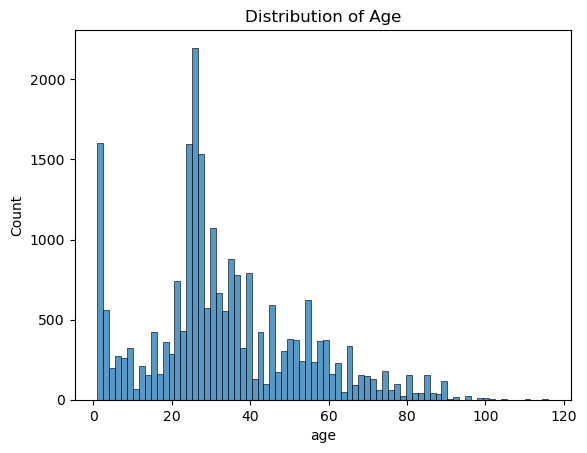

In [13]:
sns.histplot(data.age).set(title="Distribution of Age")

C:\Users\sri03\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sri03\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of Gender')]

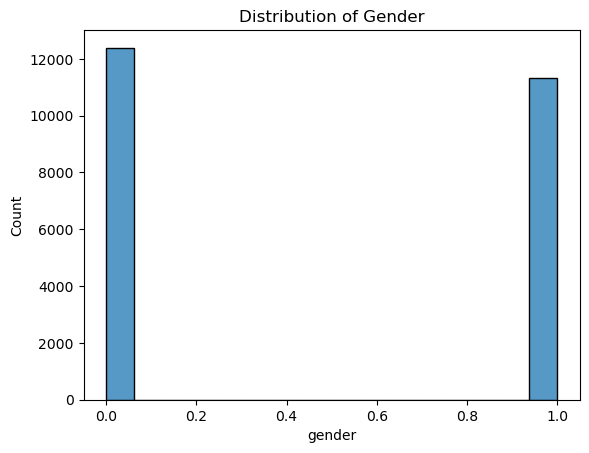

In [14]:
sns.histplot(data.gender).set(title="Distribution of Gender")

In [15]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [16]:
import numpy as np
from PIL import Image


x_train = []
for image_path in train.image:
    img = Image.open("C:/Users/sri03/Downloads/archive (8)/UTKFace/" + image_path).convert('L')
    img = img.resize((128, 128), Image.LANCZOS)  
    img = np.array(img)
    x_train.append(img)


x_train = np.array(x_train)


x_train = x_train.reshape(len(x_train), 128, 128, 1)

In [17]:
x_train.shape

(18966, 128, 128, 1)

In [18]:
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [19]:
input_size = (128,128,1)

In [20]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [21]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 126, 126, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)           0         ['batch_normalization[0][0

In [23]:
history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=5, validation_split= 0.1)

Epoch 1/5
1707/1707 [==============================] - 735s 429ms/step - loss: 12.2071 - gender_output_loss: 0.4778 - age_output_loss: 11.7294 - gender_output_accuracy: 0.7766 - age_output_accuracy: 0.0187 - val_loss: 14.6024 - val_gender_output_loss: 0.4459 - val_age_output_loss: 14.1565 - val_gender_output_accuracy: 0.7923 - val_age_output_accuracy: 0.0163
Epoch 2/5
1707/1707 [==============================] - 730s 428ms/step - loss: 9.4083 - gender_output_loss: 0.3448 - age_output_loss: 9.0636 - gender_output_accuracy: 0.8438 - age_output_accuracy: 0.0056 - val_loss: 13.5832 - val_gender_output_loss: 0.3818 - val_age_output_loss: 13.2014 - val_gender_output_accuracy: 0.8187 - val_age_output_accuracy: 0.0053
Epoch 3/5
1707/1707 [==============================] - 724s 424ms/step - loss: 8.5025 - gender_output_loss: 0.3032 - age_output_loss: 8.1993 - gender_output_accuracy: 0.8648 - age_output_accuracy: 0.0040 - val_loss: 9.3434 - val_gender_output_loss: 0.3451 - val_age_output_loss: 8

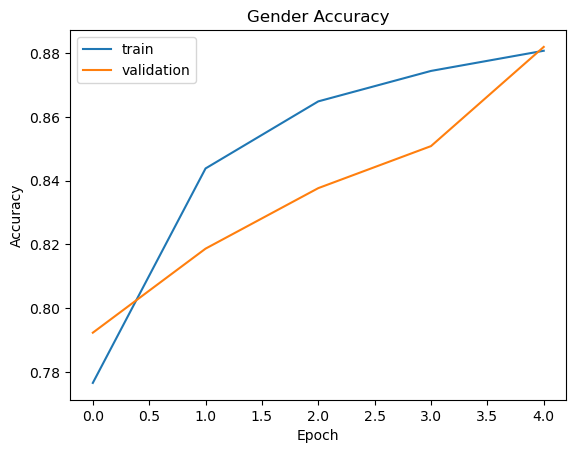

In [24]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

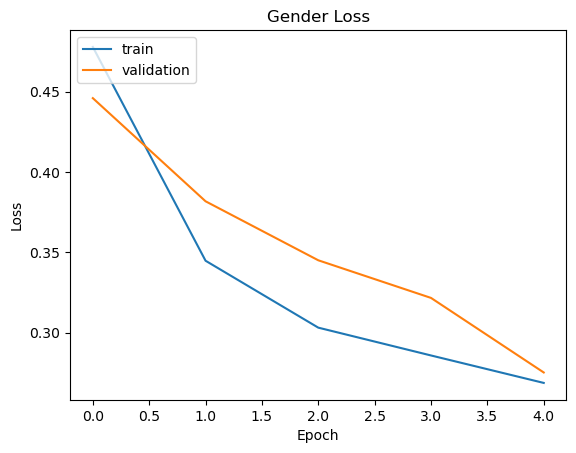

In [25]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('Gender Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

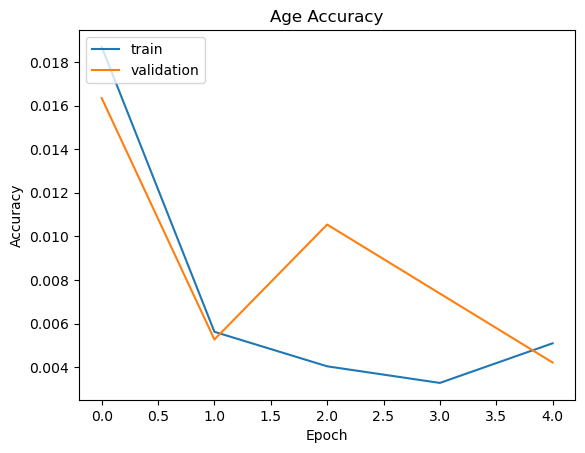

In [26]:
plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.title('Age Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

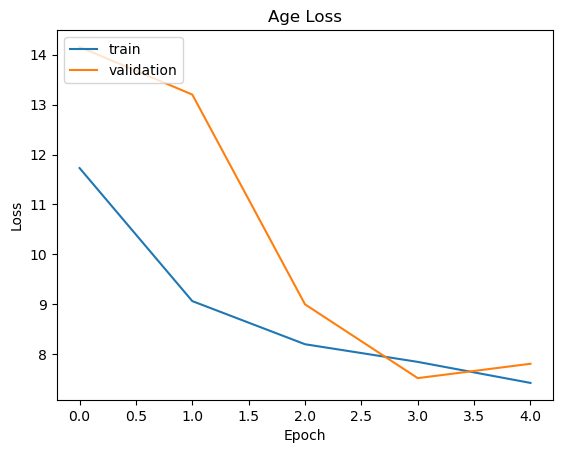

In [27]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('Age Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Original: Gender =  Male  Age =  34.0
1/1 [==============================] - 0s 263ms/step
Prediction: Gender =  Male  Age =  43


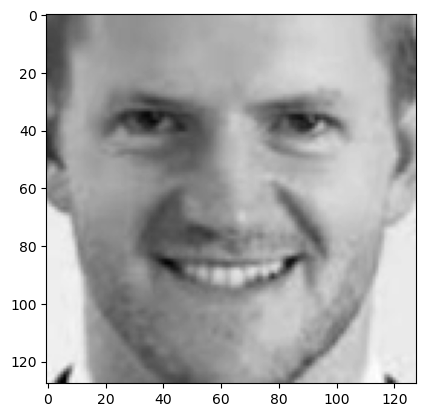

In [28]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')